In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.family"] = "NanumGothic"
mpl.rcParams["axes.unicode_minus"] = False
dep = '노인인구_기관수_비율'

In [9]:
df = pd.read_csv("../../data/elderly/pre_processing_data/rate_groupby_region_year.csv")
df.head()

,시도명,년도,노인인구_기관수_비율
0,강원특별자치도,2008,0.005100
1,강원특별자치도,2009,0.005194
2,강원특별자치도,2010,0.005223
3,강원특별자치도,2011,0.005346
4,강원특별자치도,2012,0.005325


In [10]:
# 가설 A - 혼합설계 ANOVA 주요 가정 검정
## 혼합효과모형: 연도는 고정효과, 시도는 랜덤절편
## 여기서 만들어지는 mixed lm은 분석 대상이 아님
## 그저 혼합설계 ANOVA의 주요 가정 검정을 쉽게 하기 위해 만듬

model_df = df.dropna(subset=[dep, '년도', '시도명']).copy()
model_df['년도_cat'] = model_df['년도'].astype(str)

md = smf.mixedlm(f"{dep} ~ C(년도_cat)", model_df, groups=model_df["시도명"])
mdf = md.fit(reml=False)

# print(mdf.summary())
resid = mdf.resid.dropna()

c:\Users\wjdwn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [11]:
# 가설 A - 혼합설계 ANOVA 정규성 검정
## Shapiro 테스트 수행
## 실제 관측값에서 연도에 따른 평균 변화와 시도별 평균 편차를 반영한 예측값을 뺀 잔차를 이용

sample = resid if len(resid) <= 5000 else resid.sample(5000, random_state=1)
shap_w, shap_p = stats.shapiro(sample)
print("Shapiro-Wilk p-value:", shap_p)

if shap_p < 0.05:
    print("정규성 위반 가능성 ↑ → 로그변환/비모수 대안도 고려")
else:
    print("정규성 가정 크게 문제 없다고 보고 진행 가능")

## p-value: 4.169174731827808e-14
## 따라서 정규성에 대한 귀무가설을 기각 -> 정규성을 위반했을 가능성이 높음
## 따라서 log 변환 적용

Shapiro-Wilk p-value: 4.169174731827808e-14
정규성 위반 가능성 ↑ → 로그변환/비모수 대안도 고려


In [12]:
## 비율에 로그 변환 추가 + mixed lm 다시 생성
df['log_rate'] = np.log(df[dep])
model_df = df.dropna(subset=['log_rate', '년도', '시도명']).copy()
model_df['년도_cat'] = model_df['년도'].astype(str)

md_log = smf.mixedlm("log_rate ~ C(년도_cat)", model_df, groups=model_df["시도명"])
mdf_log = md_log.fit(reml=False)

resid_log = mdf_log.resid.dropna()

sample = resid_log if len(resid_log) <= 5000 else resid_log.sample(5000, random_state=1)
w, p = stats.shapiro(sample)
print("Shapiro (log model) p-value:", p)

## log 변환 이후의 p-value: 2.3580324134127744e-13
## 따라서 혼합설계 ANOVA의 사용을 포기

Shapiro (log model) p-value: 2.3580324134127744e-13


In [13]:
## 가설 A - OLS + Cluster Robust SE
## 데이터 준비
df = model_df.copy()
df["rate"] = df["노인인구_기관수_비율"]
df["시도명"] = df["시도명"].astype(str).astype("category")


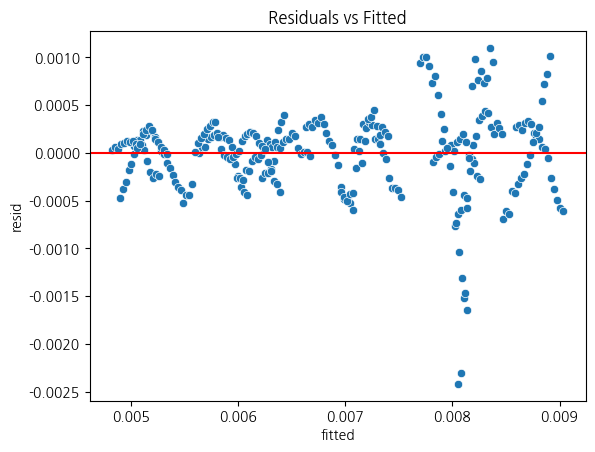

In [14]:
## 가설 A - OLS + Cluster Robust SE 선형성 확인

formula = "rate ~ C(시도명, Sum) + 년도"
ols_model = smf.ols(formula, data=df).fit()

df["fitted"] = ols_model.fittedvalues
df["resid"] = ols_model.resid

sns.scatterplot(x=df["fitted"], y=df["resid"])
plt.axhline(0, color='red')
plt.title("Residuals vs Fitted")
plt.show()

In [15]:
## 가설 A - OLS + Cluster Robust SE 다중공산성 확인
## VIF를 이용

X = pd.get_dummies(df[["시도명", "년도"]], drop_first=True)
X = X.astype(float)
X = sm.add_constant(X)

vif_df = pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print("\n===== VIF 결과 =====")
print(vif_df)


===== VIF 결과 =====
       variable            VIF
0         const  172641.646971
1            년도       1.007396
2       시도명_경기도       1.880702
3      시도명_경상남도       1.880702
4      시도명_경상북도       1.880702
5     시도명_광주광역시       1.880702
6     시도명_대구광역시       1.880702
7     시도명_대전광역시       1.880702
8     시도명_부산광역시       1.880702
9     시도명_서울특별시       1.880702
10  시도명_세종특별자치시       1.691607
11    시도명_울산광역시       1.880702
12    시도명_인천광역시       1.880702
13     시도명_전라남도       1.880702
14  시도명_전북특별자치도       1.880702
15  시도명_제주특별자치도       1.880702
16     시도명_충청남도       1.880702
17     시도명_충청북도       1.880702


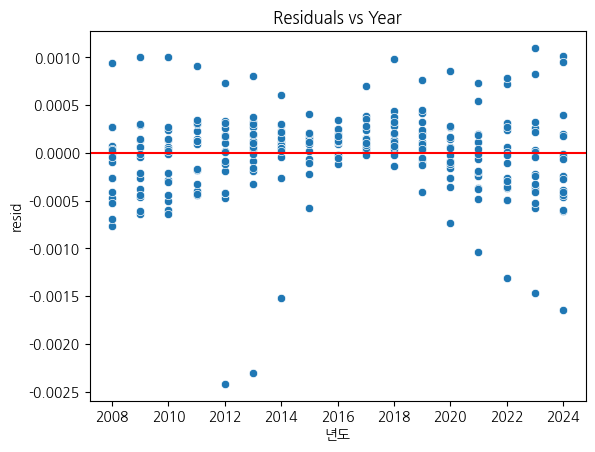

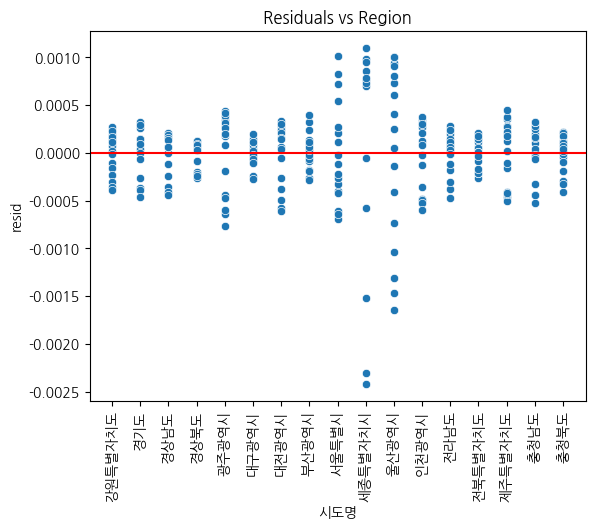

In [16]:
## 가설 A - OLS + Cluster Robust SE 외생성(Exogeneity) 확인

sns.scatterplot(x=df["년도"], y=df["resid"])
plt.axhline(0, color='red')
plt.title("Residuals vs Year")
plt.show()

sns.scatterplot(x=df["시도명"], y=df["resid"])
plt.axhline(0, color='red')
plt.title("Residuals vs Region")
plt.xticks(rotation=90)
plt.show()


In [17]:
## OLS + Cluster Robust SE
## 전국이 기준
## 모든 지역이 p-value가 0.000
## 따라서 모든 지역의 비율이 통계적으로 유의미하게 차이가 남

robust_model = ols_model.get_robustcov_results(
    cov_type="cluster",
    groups=df["시도명"]
)

print("\n===== OLS + Cluster Robust SE =====")
print(robust_model.summary())


===== OLS + Cluster Robust SE =====
                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     752.8
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           6.98e-15
Time:                        05:01:37   Log-Likelihood:                 1802.8
No. Observations:                 285   AIC:                            -3570.
Df Residuals:                     267   BIC:                            -3504.
Df Model:                          17                                         
Covariance Type:              cluster                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

c:\Users\wjdwn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [18]:
## 17개의 시도에 대한 coef 테이블 생성
import re

# 전체 계수 가져오기
param_names = ols_model.model.exog_names
coef_all = pd.Series(ols_model.params, index=param_names)

# 1) 시도명 계수만 추출
region_coef = coef_all[
    coef_all.index.str.contains(r"C\(시도명, Sum\)")
]

# 2) 시도명 추출
present_levels = []
for name in region_coef.index:
    m = re.search(r'\[S\.(.+?)\]', name)
    if m:
        present_levels.append(m.group(1))
    else:
        print("⚠ 파싱 실패:", name)

# 3) 전체 시도 목록
all_levels = sorted(df["시도명"].unique())

# 4) 누락된 1개 찾기
missing_level = list(set(all_levels) - set(present_levels))[0]

# 5) 효과코딩 제약 적용 → 합이 0
missing_coef = -region_coef.sum()

# 6) 전체 테이블 완성
full_table = pd.DataFrame({
    "시도명": present_levels + [missing_level],
    "coef": list(region_coef.values) + [missing_coef]
}).sort_values("coef").reset_index(drop=True)

print("\n===== 전국 기준 시도별 Effect Coding 계수 (17개 완성) =====")
print(full_table)



===== 전국 기준 시도별 Effect Coding 계수 (17개 완성) =====
        시도명      coef
0      경상북도 -0.001840
1      전라남도 -0.001769
2   강원특별자치도 -0.001633
3      충청남도 -0.001177
4      경상남도 -0.001024
5      충청북도 -0.000714
6     부산광역시 -0.000673
7   전북특별자치도 -0.000436
8     인천광역시 -0.000031
9   제주특별자치도  0.000299
10      경기도  0.000418
11    울산광역시  0.001038
12    대구광역시  0.001158
13  세종특별자치시  0.001277
14    광주광역시  0.001364
15    서울특별시  0.001812
16    대전광역시  0.001930


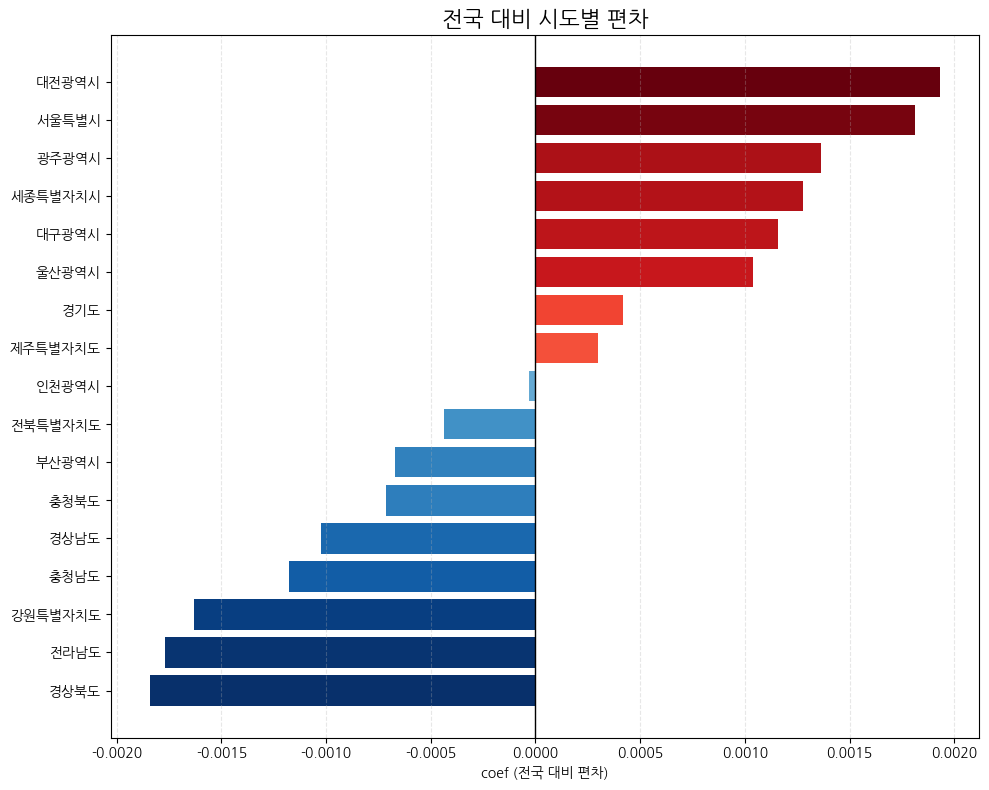

In [ ]:
## coef 테이블 시각화
dfp = full_table.sort_values("coef")

# 컬러맵 생성
cmap_neg = mpl.cm.Blues_r
cmap_pos = mpl.cm.Reds

norm = mpl.colors.Normalize(vmin=dfp["coef"].min(), vmax=dfp["coef"].max())

colors = [
    cmap_neg(norm(v)) if v < 0 else cmap_pos(norm(v))
    for v in dfp["coef"]
]

plt.figure(figsize=(10, 8))
plt.barh(
    dfp["시도명"], 
    dfp["coef"], 
    color=colors,
    edgecolor='none'
)

plt.axvline(0, color='black', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.title("전국 대비 시도별 편차", fontsize=16)
plt.xlabel("coef (전국 대비 편차)")
plt.tight_layout()
plt.show()
